# ***QUESTION 1: IMAGE PREPROCESSING***




In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [ ]:
dataset = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True
)

image_1, label_1 = dataset[0]
image_2, label_2 = dataset[1]


100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


In [ ]:
def display_images(img_list, title_list):
    plt.figure(figsize=(10, 4))
    for i in range(len(img_list)):
        plt.subplot(1, len(img_list), i + 1)
        plt.imshow(img_list[i])
        plt.title(title_list[i])
        plt.axis("off")
    plt.show()


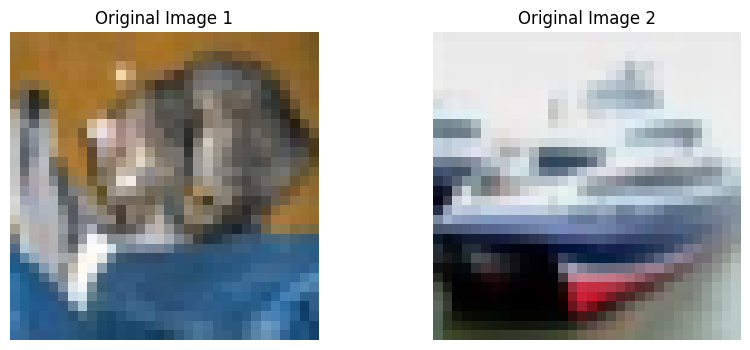

Original Image Size: (32, 32)


In [ ]:
display_images(
    [image_1, image_2],
    ["Original Image 1", "Original Image 2"]
)

print("Original Image Size:", image_1.size)


In [ ]:
image_transform = transforms.Compose([
    transforms.Resize((64, 64)),                # Resize image
    transforms.Grayscale(num_output_channels=1),# Convert to grayscale
    transforms.RandomRotation(20),              # Rotate image
    transforms.RandomHorizontalFlip(),          # Flip image
    transforms.ToTensor(),                      # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))        # Normalize values
])


In [ ]:
processed_img1 = image_transform(image_1)
processed_img2 = image_transform(image_2)

print("Processed Image Shape:", processed_img1.shape)
print("Pixel Value Range:",
      processed_img1.min().item(),
      processed_img1.max().item())


Processed Image Shape: torch.Size([1, 64, 64])
Pixel Value Range: -1.0 0.9686274528503418


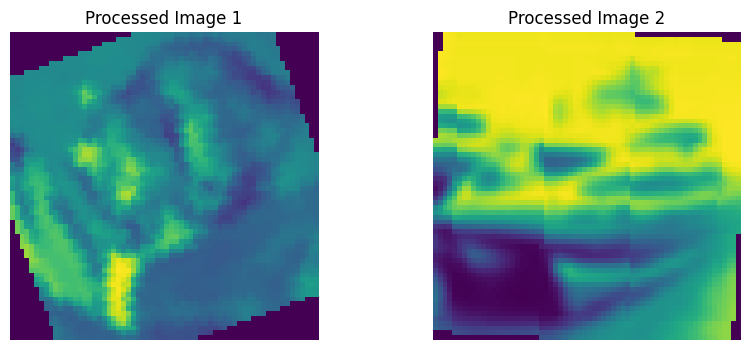

In [ ]:
display_images(
    [processed_img1.squeeze(), processed_img2.squeeze()],
    ["Processed Image 1", "Processed Image 2"]
)


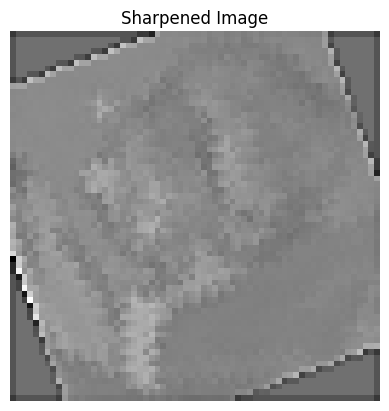

In [ ]:
sharpen_kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

sharpened_img = torch.nn.functional.conv2d(
    processed_img1.unsqueeze(0),
    sharpen_kernel,
    padding=1
)

plt.imshow(sharpened_img.squeeze(), cmap="gray")
plt.title("Sharpened Image")
plt.axis("off")
plt.show()


In [ ]:
final_image_tensor = torch.stack([processed_img1, processed_img2])
print("Final Tensor Shape:", final_image_tensor.shape)


Final Tensor Shape: torch.Size([2, 1, 64, 64])


# ***QUESTION 2: VOICE PREPROCESSING***

In [ ]:
import librosa
import torch
import matplotlib.pyplot as plt


In [ ]:
# Load audio using librosa
audio_1, sr_1 = librosa.load("sample-3s.wav", sr=None)
audio_2, sr_2 = librosa.load("sample-6s.wav", sr=None)

print(sr_1, sr_2)


44100 44100


In [ ]:
audio_1 = torch.tensor(audio_1).unsqueeze(0)
audio_2 = torch.tensor(audio_2).unsqueeze(0)


In [ ]:
audio_1 = torch.tensor(
    librosa.resample(
        y=audio_1.squeeze().numpy(),
        orig_sr=sr_1,
        target_sr=16000
    )
).unsqueeze(0)

audio_2 = torch.tensor(
    librosa.resample(
        y=audio_2.squeeze().numpy(),
        orig_sr=sr_2,
        target_sr=16000
    )
).unsqueeze(0)


In [ ]:
audio_1 = audio_1 / audio_1.abs().max()
audio_2 = audio_2 / audio_2.abs().max()


In [ ]:
def trim_silence(signal, threshold=0.02):
    mask = signal.abs() > threshold
    return signal[:, mask.squeeze()]

audio_1_clean = trim_silence(audio_1)
audio_2_clean = trim_silence(audio_2)


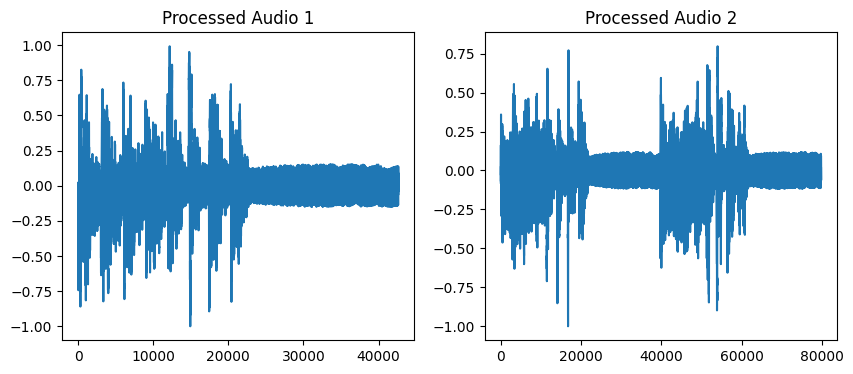

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(audio_1_clean[0])
plt.title("Processed Audio 1")

plt.subplot(1,2,2)
plt.plot(audio_2_clean[0])
plt.title("Processed Audio 2")

plt.show()


In [ ]:
mfcc_1 = librosa.feature.mfcc(
    y=audio_1_clean.squeeze().numpy(),
    sr=16000,
    n_mfcc=13
)

mfcc_2 = librosa.feature.mfcc(
    y=audio_2_clean.squeeze().numpy(),
    sr=16000,
    n_mfcc=13
)


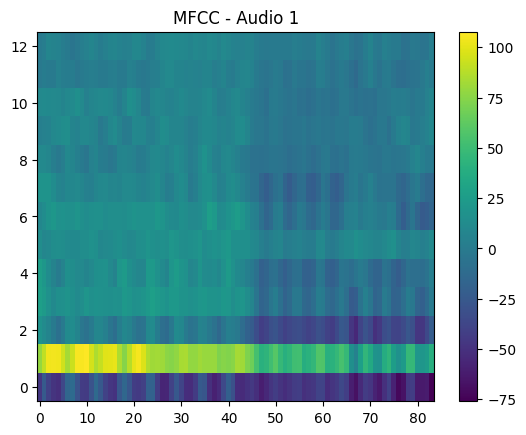

In [ ]:
plt.imshow(mfcc_1, aspect="auto", origin="lower")
plt.colorbar()
plt.title("MFCC - Audio 1")
plt.show()


In [ ]:
print(mfcc_1.shape)
print(mfcc_2.shape)



(13, 84)
(13, 156)


In [ ]:
import numpy as np

max_length = max(mfcc_1.shape[1], mfcc_2.shape[1])

def pad_mfcc(mfcc, max_len):
    pad_width = max_len - mfcc.shape[1]
    return np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')

mfcc_1_padded = pad_mfcc(mfcc_1, max_length)
mfcc_2_padded = pad_mfcc(mfcc_2, max_length)


In [ ]:
final_audio_tensor = torch.tensor(
    np.array([mfcc_1_padded, mfcc_2_padded])
)

print("Final Feature Tensor Shape:", final_audio_tensor.shape)


Final Feature Tensor Shape: torch.Size([2, 13, 156])
